# Introduction

Dans ce TP, vous disposez d’un jeu de données sur la maintenance prédictive. L’idée est de comprendre :

  - Quelles sont les colonnes réellement utiles pour prédire les pannes ?
  - Comment créer de nouvelles caractéristiques (features) qui améliorent la - pertinence de votre futur modèle ?
  - Quelles colonnes risquent de fausser la prédiction (fuites de données, données non pertinentes, identifiants, etc.) ?

À la fin, vous aurez un DataFrame nettoyé et enrichi, prêt à être utilisé pour l’entraînement d’un modèle de Machine Learning (dans un TP ultérieur).

# Importation des librairies et chargement des données

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


url = "https://raw.githubusercontent.com/DlDI/predective-maintenance/refs/heads/main/predictive_maintenance.csv"


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# À propos du Dataset

Ce dataset est une simulation représentant des cas de maintenance prédictive en industrie. Il contient des données sur des machines et leurs conditions de fonctionnement, permettant d’analyser les causes de panne.

Description des colonnes :

    UID : Identifiant unique (de 1 à 10 000).

    productID : Code produit avec une lettre L, M ou H indiquant la qualité (L = basse, M = moyenne, H = haute).

    air temperature [K] : Température ambiante autour de 300 K, avec de petites variations.

    process temperature [K] : Température du processus, toujours 10 K de plus que la température de l’air.

    rotational speed [rpm] : Vitesse de rotation basée sur une puissance de 2860 W, avec des fluctuations.

    torque [Nm] : Moyenne de 40 Nm, sans valeurs négatives.

    tool wear [min] : Usure de l’outil, variant selon la qualité du produit

    machine failure : Indique si la machine est en panne.

    Target : Indique si la machine est en panne (Oui/Non).
    
    Failure Type : Indique le type de panne.

⚠ Certaines colonnes contiennent des informations sur l’état de la machine et ne doivent pas être utilisées comme entrées dans un modèle prédictif. Les inclure fausserait les résultats en apportant une information que l’on cherche justement à prédire.

In [72]:
df = pd.read_csv(url)

## Exploration des Données

Q1 - Affichez les 9 premières lignes du dataset. Quelle est la taille (nombre de lignes et de colonnes) du dataset ?

Indices : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html#pandas-dataframe-head /
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html#pandas-dataframe-shape



In [73]:
df = pd.read_csv(url)

df.head(9)



,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure


In [74]:
df.shape


(10000, 10)

Réponse  :

Q2 - Y a-t-il des valeurs manquantes dans les données ? Si oui, dans quelles colonnes et combien ?

indice : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas-dataframe-isnull / https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html#pandas.DataFrame.sum




In [75]:
df.isnull().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


Réponse  :

## Analyse Statistique

Q3 - Quelle est la moyenne, la médiane et l’écart-type des températures (Air et Process) pour chaque type de machine (M, L et H) ?

indice : https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.agg.html#pandas-core-groupby-dataframegroupby-agg

In [76]:
temperature_stats = df.groupby('Type').agg(
    {'Air temperature [K]': ['mean', 'median', 'std'],
     'Process temperature [K]': ['mean', 'median', 'std']}
)
temperature_stats


Air temperature [K]                  Process temperature [K]         \
                    mean median       std                    mean median   
Type                                                                       
H             299.866999  299.8  2.021831              309.925723  309.9   
L             300.015833  300.1  1.987453              310.012300  310.1   
M             300.029263  300.1  2.017358              310.018785  310.0   

                
           std  
Type            
H     1.489362  
L     1.475247  
M     1.498407

Q4 - Calculer la vitesse moyenne de rotation et le couple moyen par type de machine

indice : https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.mean.html#pandas-core-groupby-dataframegroupby-mean

In [77]:
rpm_torque_stats = df.groupby('Type').agg(
    {'Rotational speed [rpm]': 'mean',
     'Torque [Nm]': 'mean'}
)

rpm_torque_stats


,Rotational speed [rpm],Torque [Nm]
Type,,
H,1538.147557,39.838285
L,1539.469167,39.996600
M,1537.598932,40.017251


# Visualisation des Données

[Matplotlib](https://matplotlib.org/stable/) est une bibliothèque de visualisation en Python permettant de créer des graphiques statiques, interactifs et animés. Elle est couramment utilisée pour analyser des données sous forme de courbes, histogrammes ou nuages de points.

[Seaborn](https://seaborn.pydata.org/index.html) est une bibliothèque de visualisation basée sur Matplotlib, conçue pour simplifier la création de graphiques statistiques élégants et informatifs.


Q5 - Tracer un histogramme des températures de l'air et du processus

indice : https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn-histplot

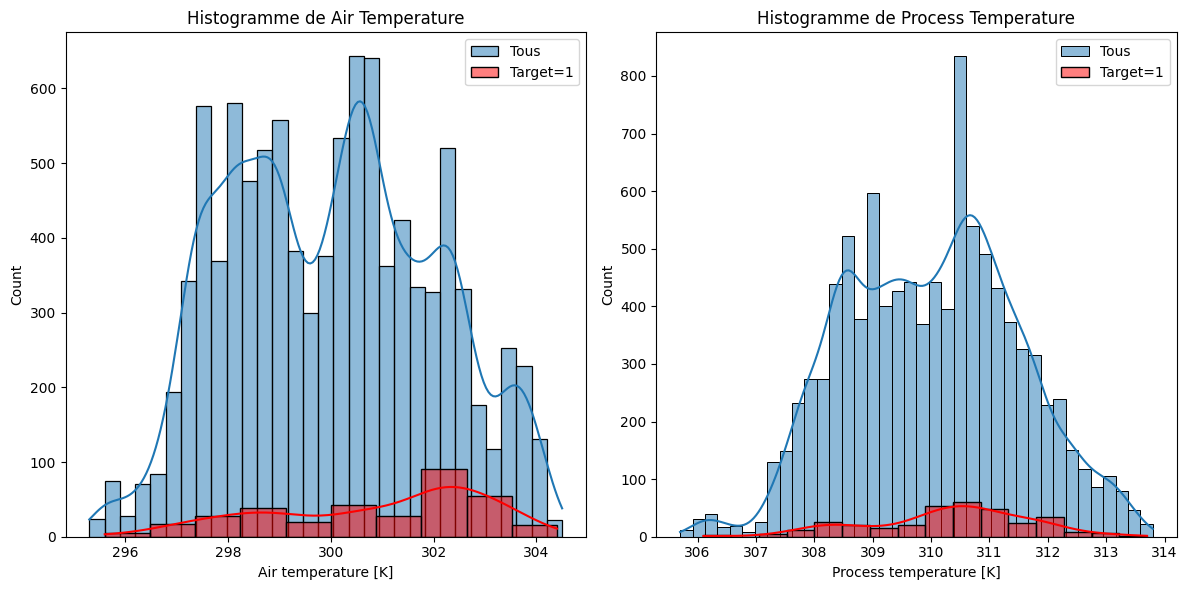

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Histogramme pour 'Air temperature [K]'
plt.subplot(1, 2, 1)
# Distribution globale
sns.histplot(df['Air temperature [K]'], kde=True, label='Tous')
# Distribution pour target == 1 en rouge
sns.histplot(df[df['Target'] == 1]['Air temperature [K]'], kde=True, color='red', label='Target=1', alpha=0.5)
plt.title('Histogramme de Air Temperature')
plt.legend()

# Histogramme pour 'Process temperature [K]'
plt.subplot(1, 2, 2)
# Distribution globale
sns.histplot(df['Process temperature [K]'], kde=True, label='Tous')
# Distribution pour target == 1 en rouge
sns.histplot(df[df['Target'] == 1]['Process temperature [K]'], kde=True, color='red', label='Target=1', alpha=0.5)
plt.title('Histogramme de Process Temperature')
plt.legend()

plt.tight_layout()
plt.show()


Q6 - Tracer un nuage de points entre la vitesse de rotation et le couple, Interprétez ce graphique.

indice : https://seaborn.pydata.org/generated/seaborn.scatterplot.html#seaborn-scatterplot

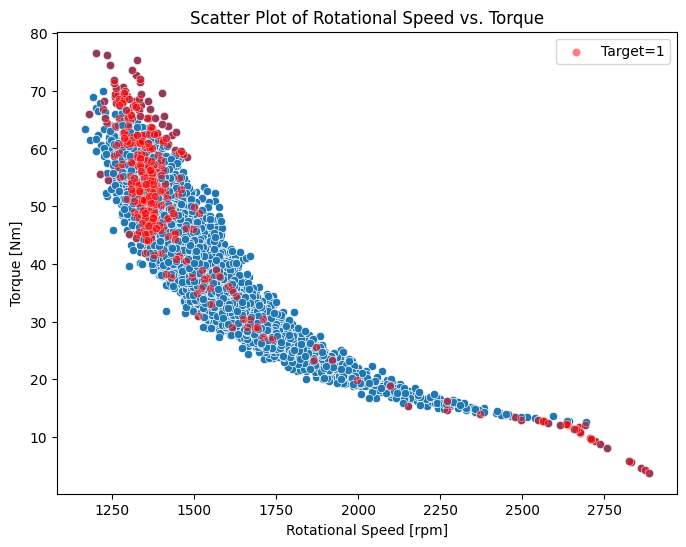

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', data=df)
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', data=df[df['Target'] == 1], color='red', label='Target=1', alpha=0.5)

plt.title('Scatter Plot of Rotational Speed vs. Torque')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()


### Matrice de Corrélation

En **apprentissage automatique**, la matrice de corrélation permet d’identifier les **redondances entre variables**, optimisant ainsi la sélection des attributs et améliorant la généralisation des modèles. Elle est essentielle pour éviter la colinéarité, qui peut biaiser les modèles de régression linéaire et compromettre leur stabilité.

Elle facilite également **l’ingénierie des features**, en suggérant la fusion ou la transformation de variables corrélées pour en extraire des descripteurs plus pertinents. Enfin, elle est utilisée pour la réduction de dimensionnalité, permettant d’alléger les modèles et d’améliorer leur efficacité computationnelle.

Pour approfondir : https://www.simplilearn.com/tutorials/machine-learning-tutorial/feature-selection-in-machine-learning

Q7 - Créez une matrice de corrélation entre toutes les variables numériques du dataset et affichez-la

Indice : https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html#pandas-dataframe-corr / https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn-heatmap

Q8 - Quelle analyse pouvez-vous tirer de la matrice de corrélation ?

- Y a-t-il des variables redondantes qu’il serait utile de supprimer ?
- Peut-on créer de nouvelles features à partir de variables fortement corrélées ?
- Certaines corrélations peuvent-elles influencer la prédiction des défaillances ?

### Réponse  :

## Création de Nouvelles Features

Q9 - Créer une colonne pour l’écart entre température du processus et température ambiante en degrés Celsius. puis créer une colonne pour la puissance mécanique

Indice : Puissance=Couple (Nm)×Vitesse de rotation (rpm)

In [80]:
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

In [81]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

## Analyse des Défaillances

Q10 - Comparaison des machines en panne et en bon état :  
- Comptez combien de machines sont en panne et combien sont en bon état.
- Calculez la proportion de machines en panne
- Comparez les statistiques des machines en panne vs. en bon état.



# TP2 : Modélisation de Maintenance Prédictive avec Random Forest




## **Règles :**  
- Chaque synthèse après une étape compte pour **50% de la note**.  
- L'autre moitié sera basée sur la **performance et les choix des paramètres**.  
- Le **meilleur modèle** recevra **+5 points** sur la note finale.  
- *Note : L'utilisation d'outils comme GPT est autorisée, mais il est indispensable de comprendre et d'expliquer chaque étape.*

## **Contexte :**  
Dans cette séance, vous allez utiliser un modèle Random Forest pour prédire les pannes de machines. Avant de modéliser, il est essentiel de préparer vos données en :  
- **Analysant les données de la table** pour identifier les relations entre les variables,  
- Vérifiant la **matrice de corrélation** pour repérer et supprimer les informations redondantes,  
- Appliquant une **mise à l'échelle** avec MinMaxScaler,  
- Et finalement, en évaluant le modèle pour mesurer ses performances.

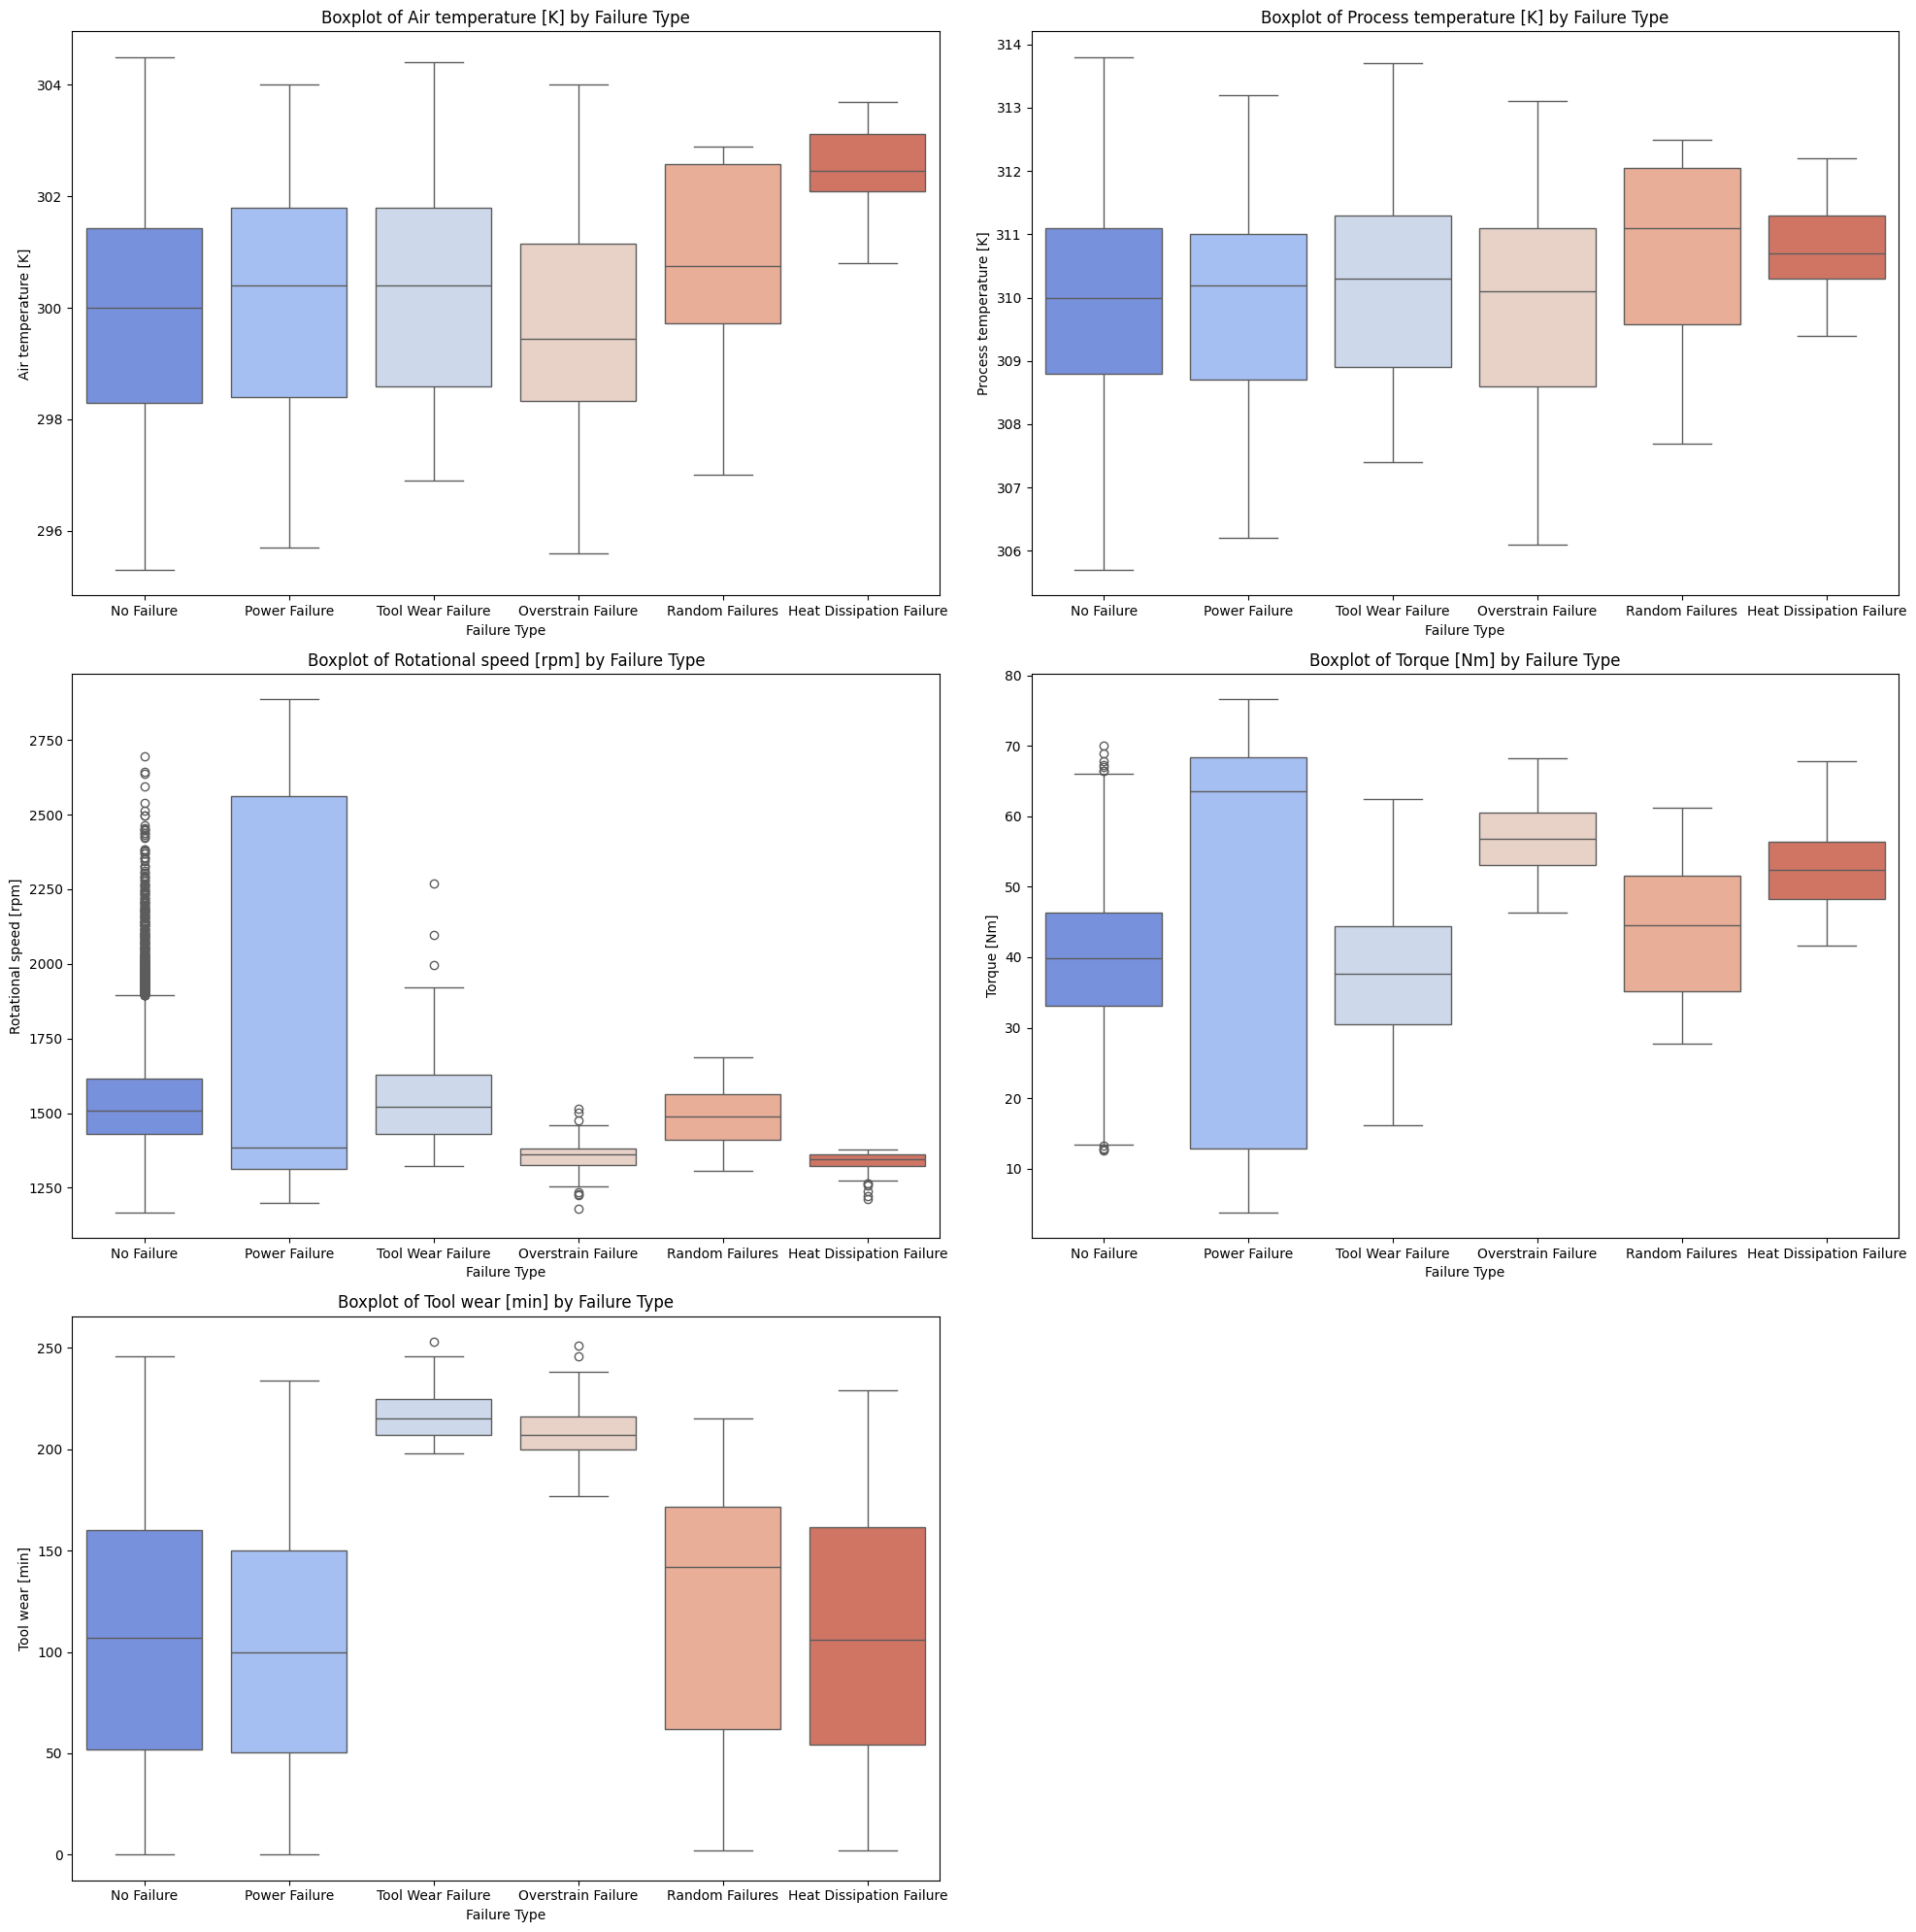

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns


# List of key variables to analyze
variables = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(20 , 20))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Failure Type', y=var, data=df, hue='Failure Type', palette='coolwarm', legend=False)
    plt.title(f'Boxplot of {var} by Failure Type')
plt.tight_layout()
plt.show()


# Q1 : Analyse des Données par Type de Failure

- **Que révèlent les statistiques ?**  
- **Quelles différences observez-vous entre les machines en panne et celles en bon état ?**

# Réponse :





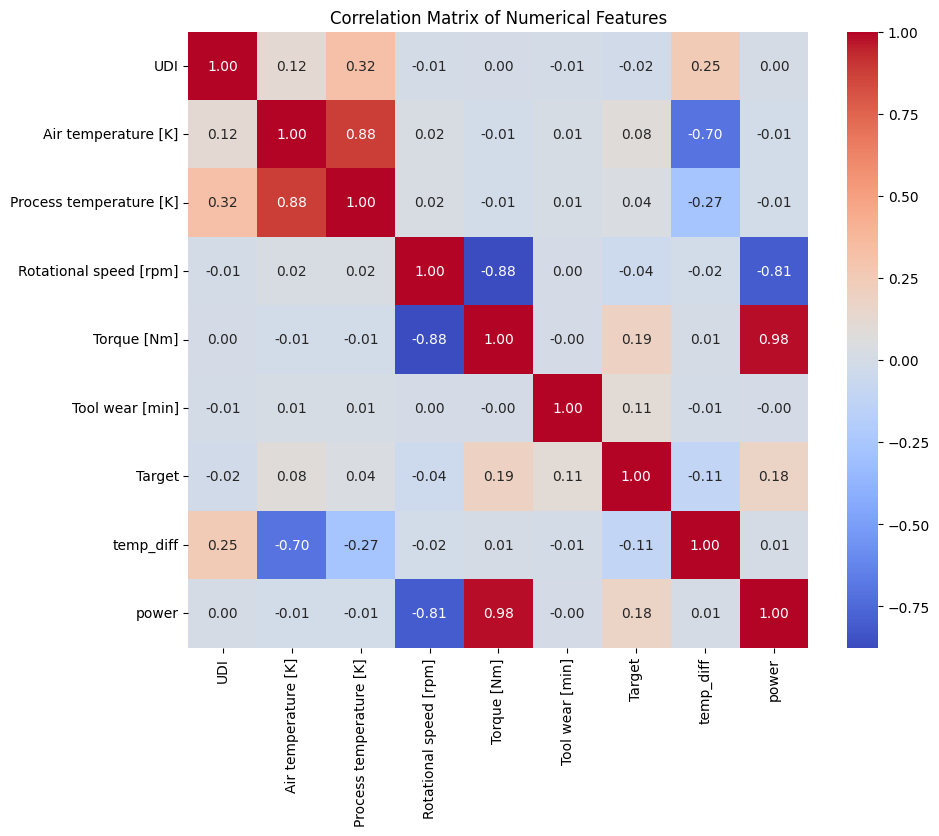

In [83]:
import matplotlib.pyplot as plt


numerical_df = df.select_dtypes(include=np.number)


correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Q2 : Analyse de la Matrice de Corrélation
Examinez la matrice de corrélation obtenue à partir de vos données pour identifier les relations entre les variables.



# Réponse :

## Séparation des Données

Nous allons **diviser** notre dataset en deux ensembles :
- **Entraînement (train)** : pour apprendre les paramètres du modèle
- **Test** : pour évaluer la capacité de généralisation du modèle

Il est important de **ne pas** mélanger les données d’entraînement et de test afin d’obtenir une évaluation objective des performances.

pour cette partie vous pouvez changer le parametre ***split_size*** pour modifier les performances

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# On sépare les features (X) et la target (y)
df = df.drop(['UDI'], axis=1, errors='ignore')
df = pd.get_dummies(df, columns=['Type'])
X = df.drop(['Target', 'UDI', 'Product ID', 'Failure Type', 'machine failure'], axis=1, errors='ignore')
y = df['Target']

In [85]:
split_size = 0.3 # valeur entre 0 et 1
# Division train/test (80% pour l'entraînement, 30% pour le test, par exemple)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=split_size,
    random_state=42  # Pour la reproductibilité
)

print("Taille de X_train :", X_train.shape)
print("Taille de X_test  :", X_test.shape)


Taille de X_train : (7000, 10)
Taille de X_test  : (3000, 10)


In [86]:
X_train

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],temp_diff,power,Type_H,Type_L,Type_M
9069,297.2,308.2,1678,28.1,133,11.0,47151.8,False,False,True
2603,299.3,309.2,1334,46.3,31,9.9,61764.2,False,False,True
7738,300.5,312.0,1263,60.8,146,11.5,76790.4,False,False,True
1579,298.3,308.3,1444,43.8,176,10.0,63247.2,False,True,False
5058,303.9,312.9,1526,42.5,194,9.0,64855.0,False,True,False
...,...,...,...,...,...,...,...,...,...,...
5734,302.3,311.8,1369,56.2,208,9.5,76937.8,False,True,False
5191,304.0,313.2,1416,46.0,128,9.2,65136.0,False,True,False
5390,302.8,312.3,1483,47.2,223,9.5,69997.6,True,False,False
860,296.1,306.9,1541,32.6,33,10.8,50236.6,True,False,False


## Mise à l'Échelle des Features et Visualisation

Nous appliquons le MinMaxScaler pour mettre toutes les features sur une échelle commune [0, 1].  
Avant et après scaling, visualisez la distribution d'une feature pour comprendre l'impact du scaling.  
*Lien utile : [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)*

In [87]:
from sklearn.preprocessing import MinMaxScaler

# Application du MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## 5. Paramétrage du Modèle Random Forest

Utilisez GridSearchCV pour ajuster les paramètres du Random Forest et optimiser la performance du modèle.  
*Lien utile : [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)*

### Explication des paramètres et de la fonction

- **GridSearchCV** :  
  Cette fonction recherche dans une grille de paramètres les meilleures combinaisons en évaluant chaque configuration à l'aide d'une validation croisée.  
  Dans notre cas, elle teste différentes valeurs de `n_estimators` et `max_depth` et utilise le score F1 pour déterminer la performance optimale.  
  Cela permet d'optimiser le modèle tout en gardant les autres paramètres à leurs valeurs par défaut pour simplifier la recherche.

- **n_estimators** :  
  Ce paramètre détermine le nombre d'arbres dans la forêt aléatoire. Plus il y a d'arbres, meilleure est généralement la performance du modèle, mais cela augmente aussi le temps d'entraînement.

- **max_depth** :  
  Ce paramètre fixe la profondeur maximale des arbres. Si `max_depth` est défini sur `None`, les arbres pourront se développer jusqu'à ce que toutes les feuilles soient pures ou que le nombre d'échantillons par feuille soit inférieur à `min_samples_split`.






In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ None,10, 20]
}


rf = RandomForestClassifier(random_state=42, class_weight='balanced')


grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)


print("Best parameters found:", grid_rf.best_params_)
rf_best = grid_rf.best_estimator_


Best parameters found: {'max_depth': 10, 'n_estimators': 300}


## 6. Évaluation du Modèle

Affichez le rapport de classification et la matrice de confusion pour analyser la performance du modèle.  
Expliquez ce que signifient les métriques :  


=== Rapport de Classification Random Forest ===
              precision    recall  f1-score   support
0              0.990099  0.997592  0.993831  2907.000
1              0.901408  0.688172  0.780488    93.000
accuracy       0.988000  0.988000  0.988000     0.988
macro avg      0.945754  0.842882  0.887160  3000.000
weighted avg   0.987350  0.988000  0.987218  3000.000


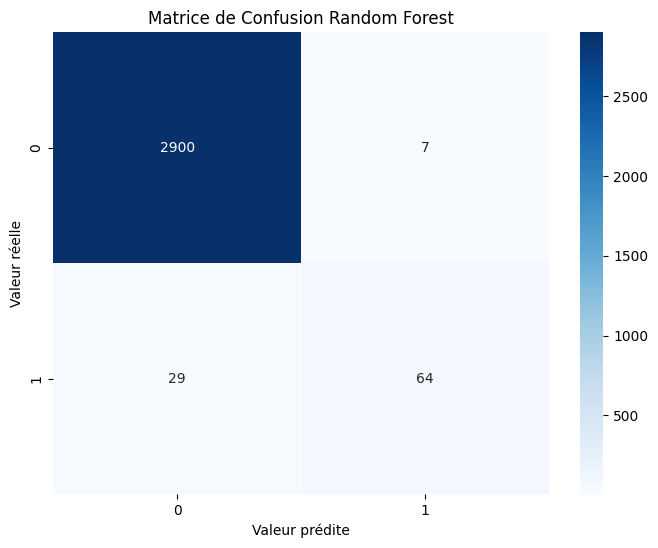

In [90]:
from sklearn.metrics import classification_report, confusion_matrix

# Prédictions sur le jeu de test
y_pred_rf = rf_best.predict(X_test_scaled)

# Affichage des résultats
report = classification_report(y_test, y_pred_rf, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("=== Rapport de Classification Random Forest ===")
print(df_report)
# Générer et afficher la matrice de confusion avec un heatmap
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion Random Forest')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.show()

In [91]:
from sklearn.model_selection import train_test_split, cross_val_score

f1_test = cross_val_score(rf_best, X_test_scaled, y_test, cv=5, scoring='f1')
f1_test.mean()

0.5884804850322091

In [92]:
X_test

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],temp_diff,power,Type_H,Type_L,Type_M
6252,300.8,310.3,1538,36.1,198,9.5,55521.8,False,True,False
4684,303.6,311.8,1421,44.8,101,8.2,63660.8,False,False,True
1731,298.3,307.9,1485,42.0,117,9.6,62370.0,False,False,True
4742,303.3,311.3,1592,33.7,14,8.0,53650.4,False,True,False
4521,302.4,310.4,1865,23.9,129,8.0,44573.5,False,True,False
...,...,...,...,...,...,...,...,...,...,...
8014,300.9,312.0,1500,44.2,188,11.1,66300.0,False,True,False
1074,297.0,307.9,1595,31.7,170,10.9,50561.5,False,True,False
3063,300.0,309.1,1431,45.4,90,9.1,64967.4,False,True,False
6487,300.6,309.8,1541,36.2,166,9.2,55784.2,True,False,False


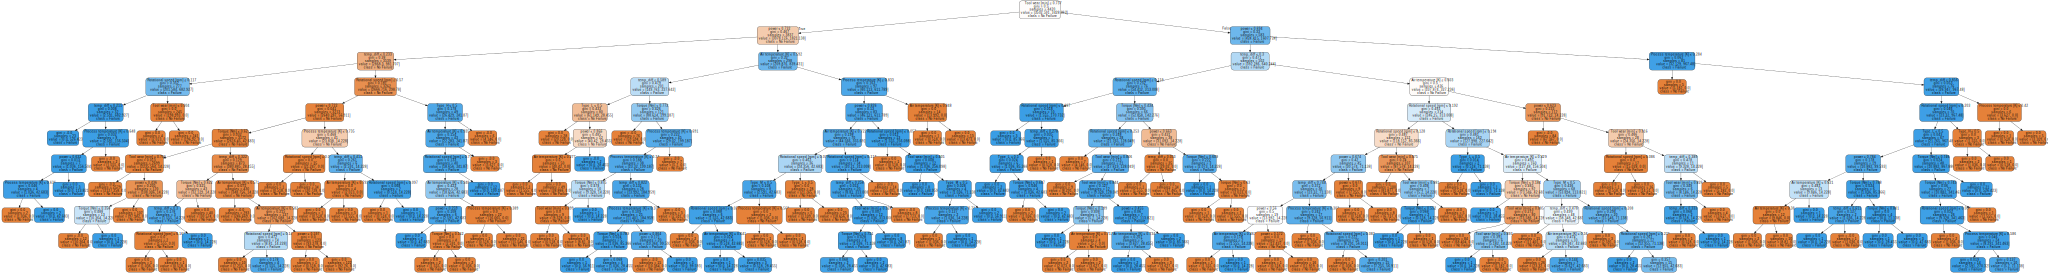

In [93]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display


# Sélectionner un arbre dans le modèle Random Forest (ici, le premier arbre)
arbre = rf_best.estimators_[0]
# Définir la liste des noms de features (assurez-vous que cette liste correspond à l'ordre des colonnes utilisées pour entraîner le modèle)
features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'temp_diff',
    'power',
    'Type_H',
    'Type_L',
    'Type_M'
]

# Pour la classification binaire :
# Classe 0 : "No Failure"
# Classe 1 : "Failure"
class_names = ["No Failure", "Failure"]

# Exporter l'arbre au format DOT sans écrire dans un fichier (on récupère la chaîne DOT directement)
dot_data = export_graphviz(
    arbre,
    out_file=None,              # Permet de récupérer la chaîne DOT directement
    feature_names=features,     # Noms des features
    class_names=class_names,    # Noms des classes
    filled=True,                # Remplit les nœuds de couleur en fonction de leur classe
    rounded=True,               # Affiche les nœuds avec des coins arrondis
    special_characters=True     # Permet l'utilisation de caractères spéciaux
)

# Créer et afficher l'arbre avec Graphviz directement dans le notebook
graph = graphviz.Source(dot_data)
display(graph)

## Synthèse et Instructions Finales

**Synthèse attendue :**
- **Chargement et Préparation :** Expliquez pourquoi il est important d'avoir des données propres et sans redondance.
- **Matrice de Corrélation :** Analysez la matrice, et indiquez quelles colonnes pourraient être supprimées pour éviter la multicolinéarité.
- **Split des Données :** Justifiez le choix du ratio de séparation et l'importance de la reproductibilité (random_state).
- **Mise à l'Échelle :** Comparez les distributions avant/après scaling et expliquez son intérêt pour la convergence des modèles.
- **Paramétrage du Modèle :** Commentez les paramètres optimisés via GridSearchCV et leur impact sur la performance.
- **Évaluation :** Expliquez la matrice de confusion et interprétez les métriques (accuracy, precision, recall, f1-score) pour expliquer la performance du modèle.

**Critères d'Évaluation :**
- **50% pour la synthèse et l'explication** de chaque partie du code.
- **50% pour la performance du modèle** et la pertinence des choix des paramètres.
- Le meilleur modèle recevra un bonus de **+5 points** sur la note finale.

N'oubliez pas que l'objectif est de comprendre chaque étape et de pouvoir l'expliquer clairement.

# Votre synthèse :  

# classification multi-classes :

In [110]:
df

,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,temp_diff,power,Type_H,Type_L,Type_M,Failure_Type_Encoded
0,M14860,298.1,308.6,1551,42.8,0,0,No Failure,10.5,66382.8,False,False,True,1
1,L47181,298.2,308.7,1408,46.3,3,0,No Failure,10.5,65190.4,False,True,False,1
2,L47182,298.1,308.5,1498,49.4,5,0,No Failure,10.4,74001.2,False,True,False,1
3,L47183,298.2,308.6,1433,39.5,7,0,No Failure,10.4,56603.5,False,True,False,1
4,L47184,298.2,308.7,1408,40.0,9,0,No Failure,10.5,56320.0,False,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,M24855,298.8,308.4,1604,29.5,14,0,No Failure,9.6,47318.0,False,False,True,1
9996,H39410,298.9,308.4,1632,31.8,17,0,No Failure,9.5,51897.6,True,False,False,1
9997,M24857,299.0,308.6,1645,33.4,22,0,No Failure,9.6,54943.0,False,False,True,1
9998,H39412,299.0,308.7,1408,48.5,25,0,No Failure,9.7,68288.0,True,False,False,1


# TP 3 :

In [101]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Encodage de la variable cible en multi-classes
le = LabelEncoder()
df['Failure_Type_Encoded'] = le.fit_transform(df['Failure Type'])

# Facultatif : affichage du mapping
mapping = {i: label for i, label in enumerate(le.classes_)}
print("Mapping (code -> classe):", mapping)

# 2. Sélection des features (on retire les colonnes non désirées)
X_multi = df.drop(['Failure Type', 'Failure_Type_Encoded', 'UID',
                   'Product ID', 'machine failure'], axis=1, errors='ignore')
y_multi = df['Failure_Type_Encoded']

# 3. Division train/test (pour la multi-classification)
split_size = 0.3
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi,
    test_size=split_size,
    random_state=42
)

# 4. Mise à l'échelle spécifique au multi-classes
scaler = MinMaxScaler()
X_train_multi_scaled = scaler.fit_transform(X_train_multi)
X_test_multi_scaled = scaler.transform(X_test_multi)


# Define the classifier with static parameters
rf_multi_static = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)


Mapping (code -> classe): {0: 'Heat Dissipation Failure', 1: 'No Failure', 2: 'Overstrain Failure', 3: 'Power Failure', 4: 'Random Failures', 5: 'Tool Wear Failure'}


In [102]:
# Train the model
rf_multi_static.fit(X_train_multi_scaled, y_train_multi)

# Make predictions on the test set
y_pred_multi_static = rf_multi_static.predict(X_test_multi_scaled)

In [124]:
# Rapport de classification
print("=== Rapport de Classification (Multi-classes) ===")
print(classification_report(y_test_multi, y_pred_multi))



=== Rapport de Classification (Multi-classes) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00      2903
           2       0.95      0.95      0.95        22
           3       1.00      1.00      1.00        31
           4       0.00      0.00      0.00         7
           5       0.92      0.86      0.89        14

    accuracy                           1.00      3000
   macro avg       0.81      0.80      0.81      3000
weighted avg       0.99      1.00      1.00      3000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


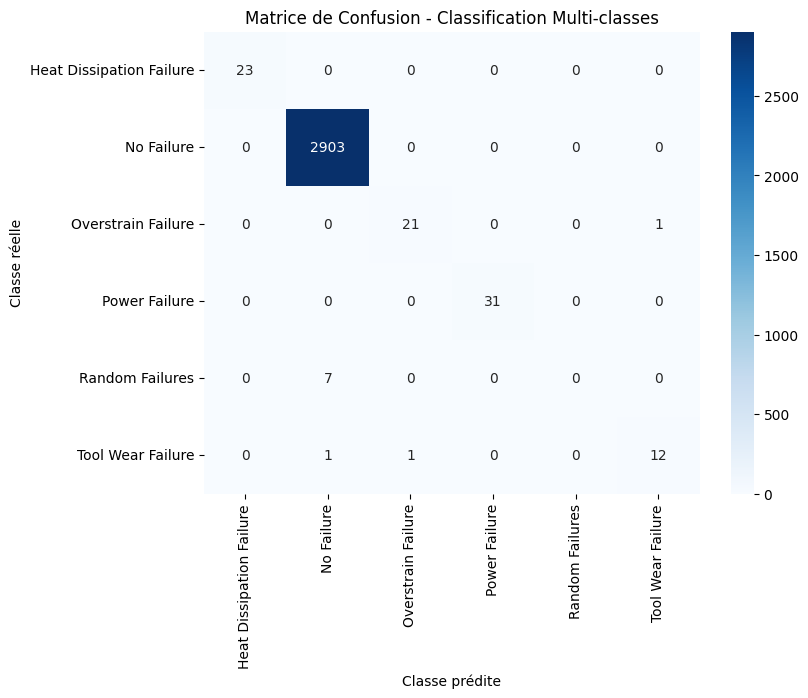

In [104]:
# Matrice de confusion
cm = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de Confusion - Classification Multi-classes')
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')


plt.show()


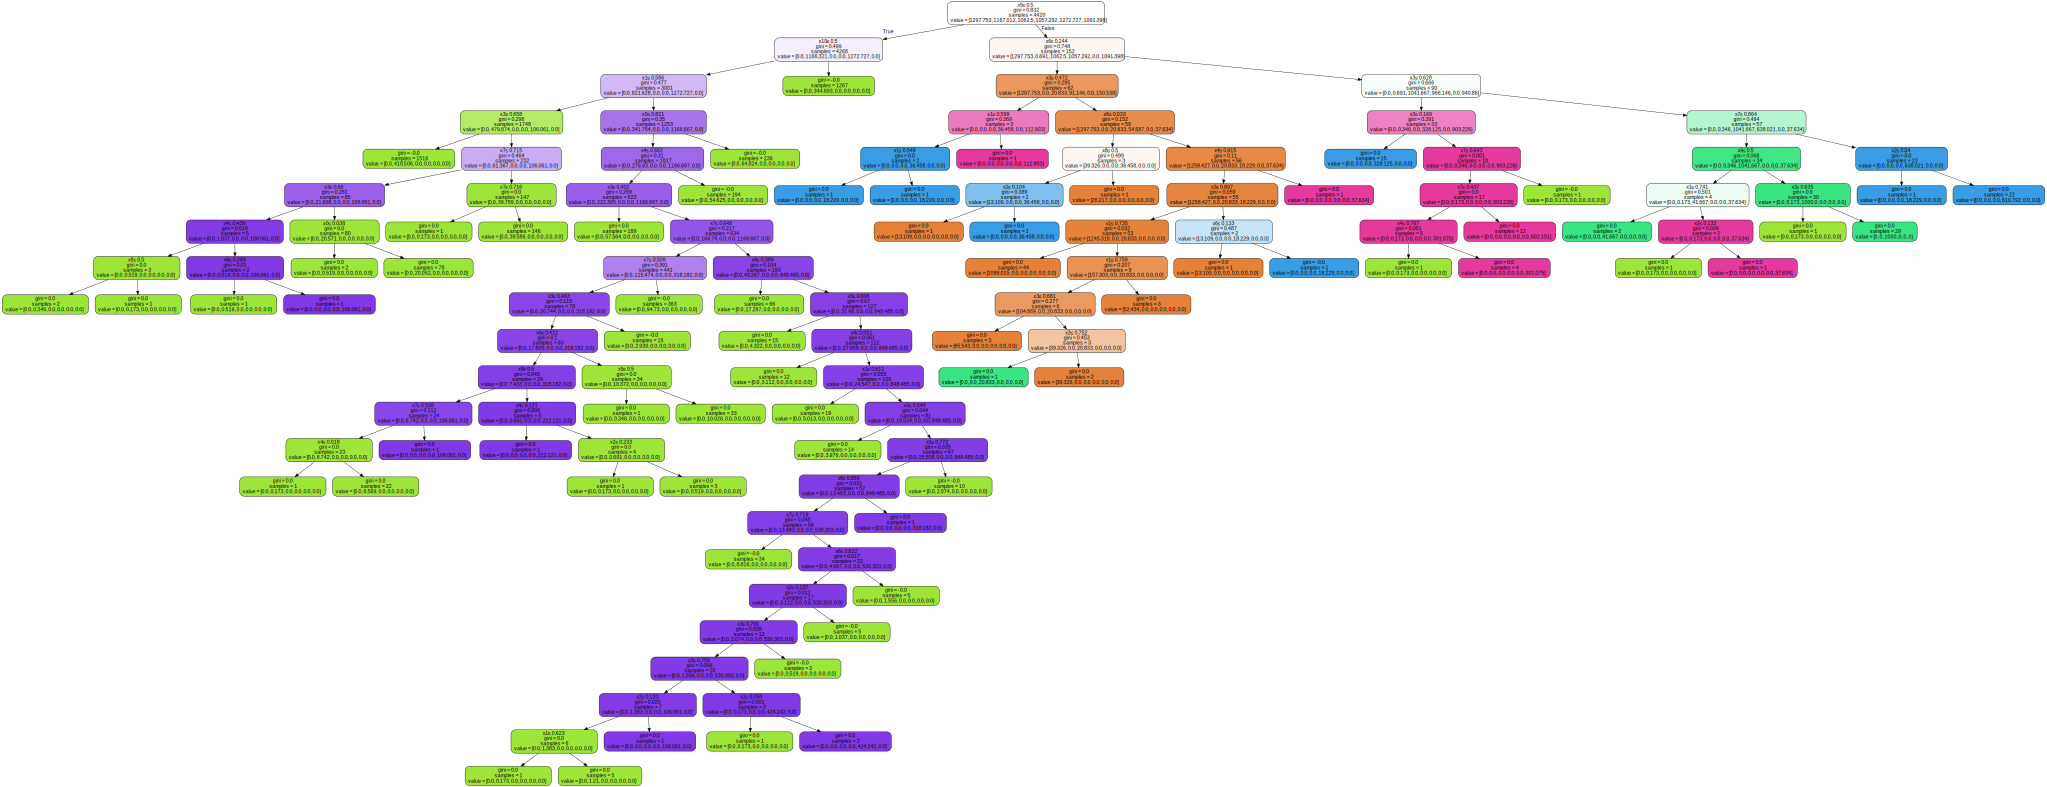

In [121]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

# Sélectionner un arbre dans le modèle Random Forest multi-classes (ici, le premier arbre)
arbre = rf_best_multi.estimators_[0]

# Définir la liste des noms de features (assurez-vous que cette liste correspond à l'ordre des colonnes utilisées pour entraîner le modèle)
features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'temp_diff',
    'test',
    'power',
    'Type_H',
    'Type_L',
    'Type_M'
]

# Pour la classification multi-classes :
# Remplacez par les noms réels de vos classes
class_names = ["Classe A", "Classe B", "Classe C"]

# Exporter l'arbre au format DOT sans écrire dans un fichier (récupération directe de la chaîne DOT)
dot_data = export_graphviz(
    arbre,
    out_file=None,              # Récupère la chaîne DOT directement
    feature_names=features,     # Noms des features
    class_names=class_names,    # Noms des classes
    filled=True,                # Coloration des nœuds en fonction de la classe majoritaire
    rounded=True,               # Nœuds avec coins arrondis
    special_characters=True     # Permet l'utilisation de caractères spéciaux
)

# Créer et afficher l'arbre avec Graphviz directement dans le notebook
graph = graphviz.Source(dot_data)
display(graph)
